# Example notebook : Dataset bias analyse for a binary classification

## Load packages

In [1]:
import numpy as np
import pandas as pd

from transparentai.datasets import StructuredDataset, load_adult
from transparentai.fairness import ModelBiasMetric

from transparentai.utils import encode_categorical_vars
import pickle

## Load adult dataset

In [2]:
adult = load_adult()

## Load model

In [3]:
with open('save/model_binary_classification.pkl', mode='rb') as file:
    clf = pickle.load(file)
file.close()

## Prepare data

In [4]:
target = 'income'
target_value = {'>50K':1, '<=50K':0}
adult[target] = adult[target].replace(target_value)

In [5]:
adult, encoders = encode_categorical_vars(adult)
X, y = adult.drop(columns=target), adult[target]

## Prepare and create DatasetBiasMetric

To create a DatasetBiasMetric you need a StructuredDataset object and a privileged_groups dictionnary where is indicate which variable is / are protected and what is the privileged values.

In [6]:
preds = pd.Series(clf.predict(X)).replace({1:'>50K', 0:'<=50K'})
y = y.replace({1:'>50K', 0:'<=50K'})

In [7]:
for var in encoders:
    X[var] = encoders[var].inverse_transform(X[var])

In [8]:
adult = pd.concat([X, y], axis=1)

In [9]:
target = 'income'
favorable_label = '>50K'
dataset = StructuredDataset(df=adult, target=target)

privileged_groups = {
    'marital-status': ['Married-civ-spouse','Married-AF-spouse'],
    'race': ['White'],
    'gender': ['Male']
}   
model_bias = ModelBiasMetric(dataset=dataset, preds=preds,
                             privileged_groups=privileged_groups,
                             favorable_label=favorable_label)

## Display dataset bias metrics & save to file

In [10]:
model_bias.get_bias_metrics()

,,Disparate impact,Statistical parity difference,Equal opportunity difference,Average abs odds difference,Theil index
attr,index,,,,,
marital-status,>50K,0.123039,-0.379758,-0.093421,0.076139,0.035101
race,>50K,0.601789,-0.096172,0.001934,0.006545,0.035101
gender,>50K,0.344035,-0.190762,-0.032314,0.027841,0.035101


In [11]:
model_bias.save_bias_metrics(fname='save/adult_model_bias_metrics_binclass.json')

## Get some insight

In [12]:
insight = model_bias.insight()
insight
for attr, bias_dict in insight.items():
    for target_value, string in bias_dict.items():
        print('---------')
        print(f'{attr} : target_value = {target_value}')
        print(string)

---------
marital-status : target_value = >50K
For this target value (>50K) regarding the 'marital-status' attribute 2 for the 5 bias metrics are/is biased so you can considered that the dataset is biased.
---------
race : target_value = >50K
For this target value (>50K) regarding the 'race' attribute 1 for the 5 bias metrics are/is biased so you can considered that the dataset is biased.
---------
gender : target_value = >50K
For this target value (>50K) regarding the 'gender' attribute 1 for the 5 bias metrics are/is biased so you can considered that the dataset is biased.


## Plot dataset bias metrics

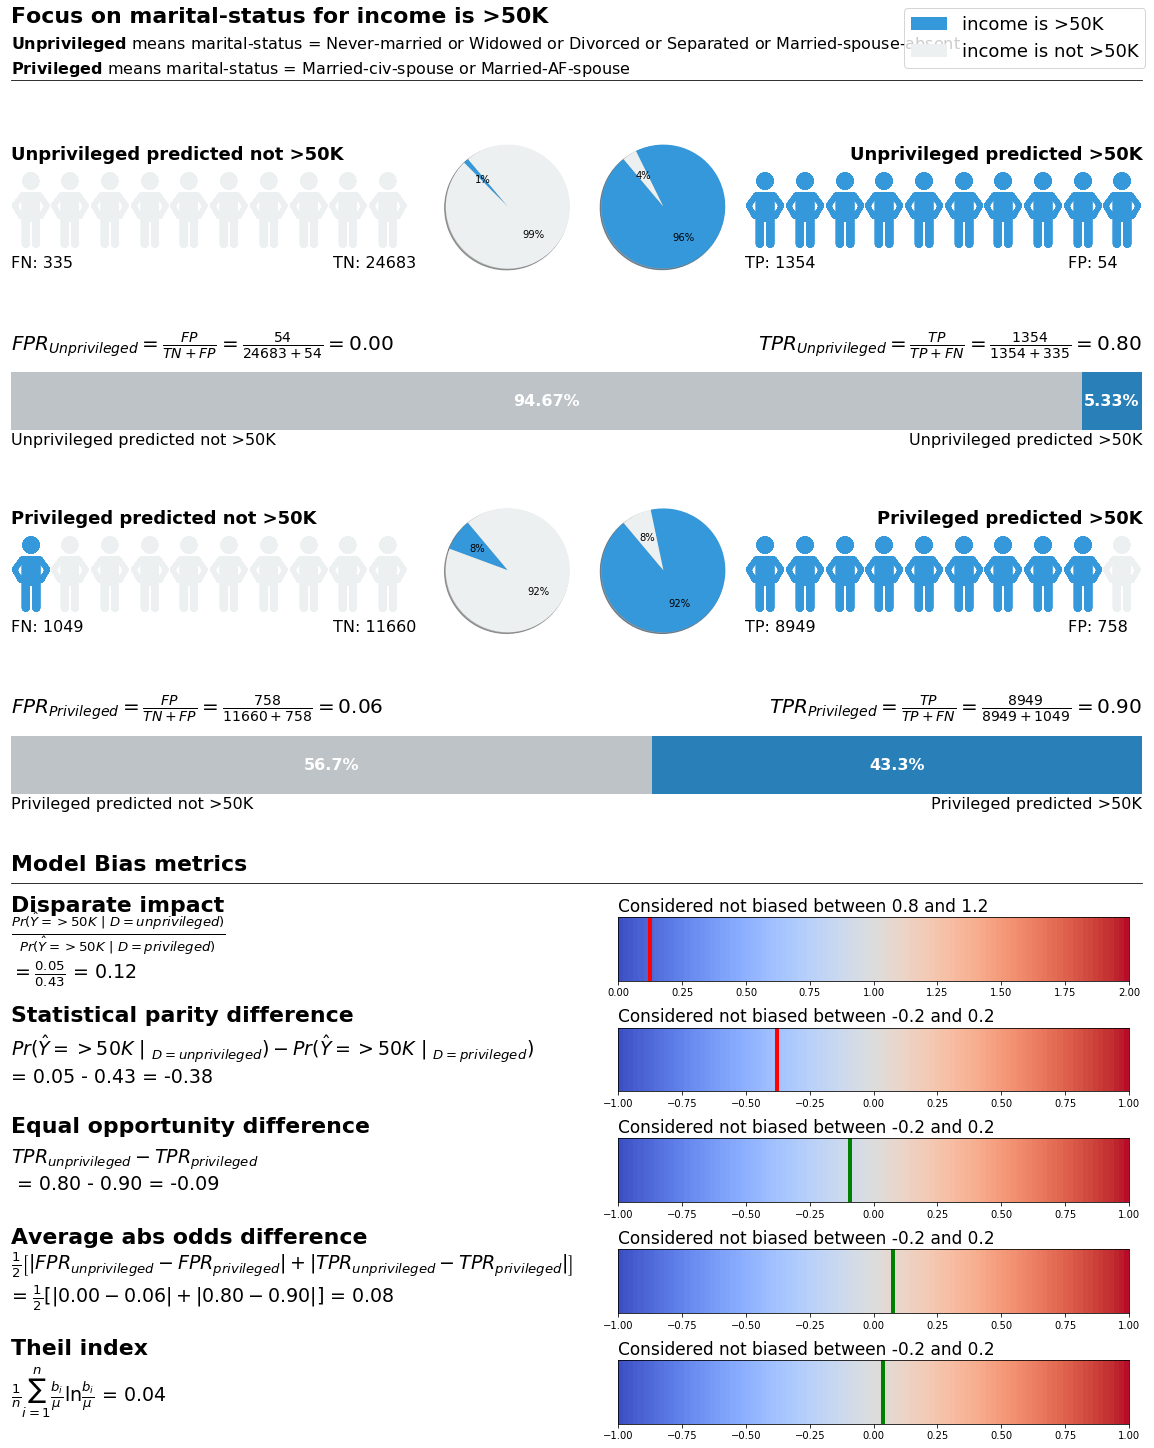

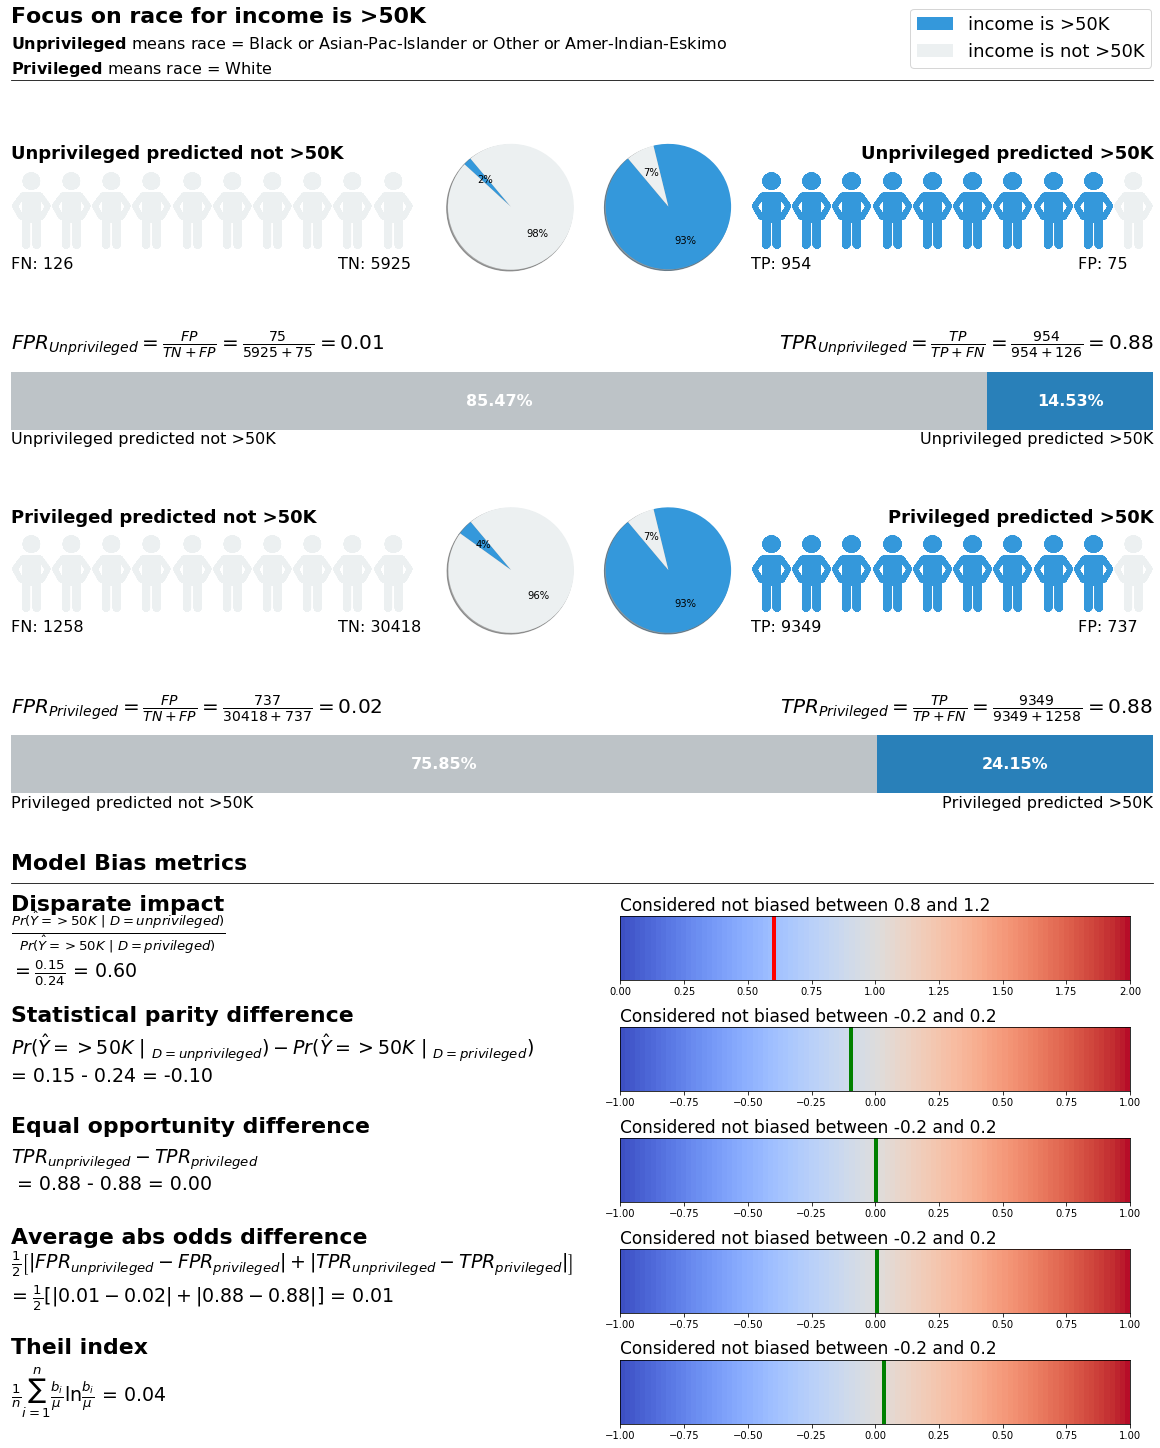

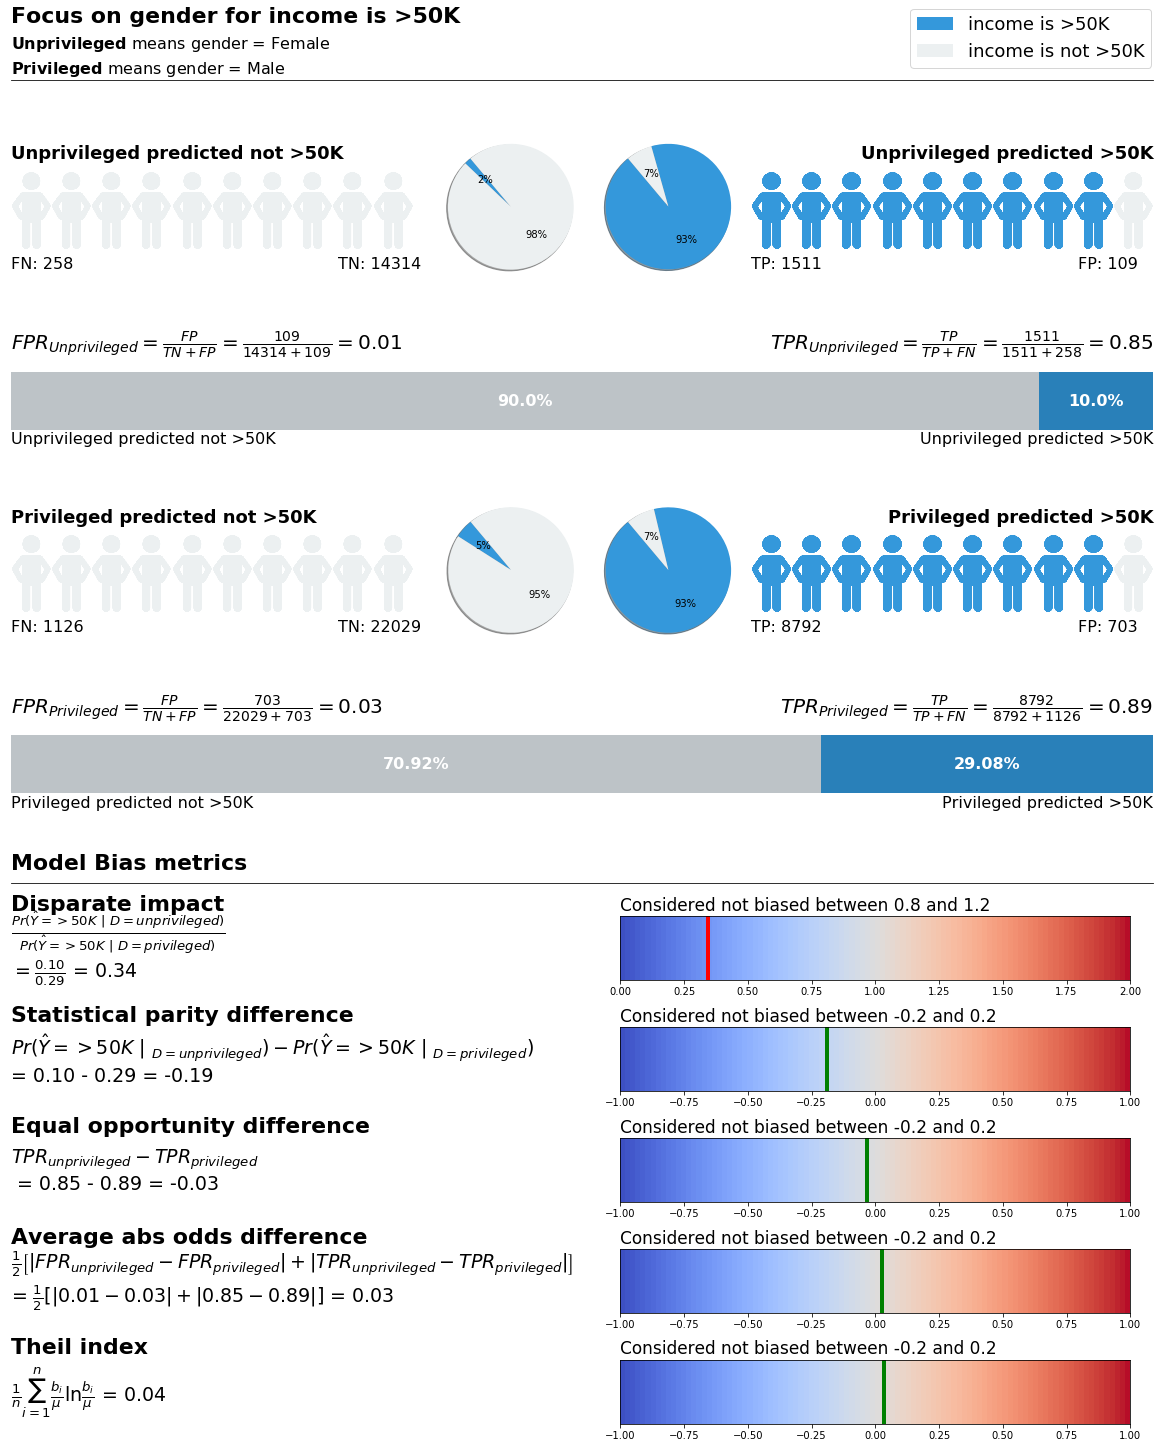

In [13]:
model_bias.plot_bias()

## The end.